## Installations and Dependencies

In [ ]:
# Installations
!pip install transformers
!pip install torchmetrics
!pip install torchxrayvision
!pip install pytorch-lightning
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
# File Management
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# Utilities
from __future__ import print_function
import argparse, random, copy
import numpy as np
import tqdm

# Torch imports
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

import torchxrayvision as xrv

# SKLearn
import sklearn
import scikitplot as skplt
from sklearn.model_selection import train_test_split

# Premade Transformers
from transformers import AutoModel

## Preprocessing

In [ ]:
# Configure Google Drive
drive.mount('/content/gdrive')

%cd "gdrive"
%cd "MyDrive"
%cd "RESEARCH - Radiological Report Generation (Troy)"
%cd "similarity"
%cd "data"
%cd "imagenome"
%cd "chestimagenome"

%ls

Mounted at /content/gdrive
/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/.shortcut-targets-by-id/1hHiAoMvTdZ3JiCE_TUlQhBagCZLqY9CD/RESEARCH - Radiological Report Generation
/content/gdrive/.shortcut-targets-by-id/1hHiAoMvTdZ3JiCE_TUlQhBagCZLqY9CD/RESEARCH - Radiological Report Generation/similarity
/content/gdrive/.shortcut-targets-by-id/1hHiAoMvTdZ3JiCE_TUlQhBagCZLqY9CD/RESEARCH - Radiological Report Generation/similarity/data
/content/gdrive/.shortcut-targets-by-id/1hHiAoMvTdZ3JiCE_TUlQhBagCZLqY9CD/RESEARCH - Radiological Report Generation/similarity/data/imagenome
/content/gdrive/.shortcut-targets-by-id/1waWP_DagIdxgFKBz0QIObNgVt9tF5-WB/Chest Imagenome (Pleural Effusion)
chest_imagenome_pleural_effusion.csv  curr_img.pickle  prev_img.pickle


### Use Imagenome Dataset

In [ ]:
# Note: subject_id -> current, object_id -> previous
csv_df = pd.read_csv("./chest_imagenome_pleural_effusion.csv")
prevpkl = pd.read_pickle("./prev_img.pickle")
currentpkl = pd.read_pickle("./curr_img.pickle")

## Base Architecture

In [ ]:
# Configurations for Siamese Network
config = {
    "d_model": 512,
    "dropout": 0.2,
    "num_classes": 2,
    "lr": 1e-3
}

# Siamese Network Architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        The siamese network architecture makes use of two parallel neural
        networks that learn to, in this case, be able to successfully
        encode and distinguish between two images.
        """
        super(SiameseNetwork, self).__init__()

        # 101-elastic is trained on PadChest, NIH, CheXpert, and MIMIC datasets
        self.cnn1 = xrv.autoencoders.ResNetAE(weights="101-elastic")
        self.nclasses = config["num_classes"]

        outdim = 512 * 3 * 3 * 2

        for param in self.cnn1.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(outdim, config["d_model"])
        self.dropout = nn.Dropout(config["dropout"], inplace=False)
        self.fc_final = nn.Linear(config["d_model"], config["num_classes"])
        self.learning_rate = config["lr"]

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output["z"].view(-1, 512*3*3)
        return output

    def forward(self, input1, input2):
        # Parallel networks in action
        prev_image_features = self.forward_once(input1)
        curr_image_features = self.forward_once(input2)

        # Combine the features, and generate the output
        image_features = torch.cat((prev_image_features, curr_image_features), 1)
        image_features = F.relu(self.fc(image_features))
        image_features = self.dropout(image_features)
        classifier_output = self.fc_final(image_features)

        return classifier_output

class SiameseDataset(Dataset):
    def __init__(self, data, prev_pkl, current_pkl):
        """
        The SiameseDataset object stores the data into something neat and accessible.
        Also, makes the images have 3->1 channel (grayscale).
        """
        super(SiameseDataset, self).__init__()
        self.data = data
        self.prev_pkl = prev_pkl
        self.current_pkl = current_pkl
        self.greyscale = torchvision.transforms.Grayscale(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_1 = self.prev_pkl[self.data["object_id"][index]]
        image_1 = self.greyscale(image_1)
        image_2 = self.current_pkl[self.data["subject_id"][index]]
        image_2 = self.greyscale(image_2)
        if self.data["comparison"][index] == "no change":
          target = 0
        else:
          target = 1

        return {"prev_img": image_1, "curr_img": image_2, "change": target}

### Just to test...

In [ ]:
# Load the dataset and dataloaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df, test_df = train_test_split(csv_df, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_ds = SiameseDataset(train_df, prevpkl, currentpkl)
test_ds = SiameseDataset(test_df, prevpkl, currentpkl)
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

# Try out one batch and see what the model spits out

batch = next(iter(train_data_loader))
batch['prev_img'] = batch['prev_img'].to(device)
batch['curr_img'] = batch['curr_img'].to(device)
batch['change'] = batch['change'].to(device)

model = SiameseNetwork().to(device)

model(batch["prev_img"], batch["curr_img"])

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nihpcrsnamimic_ch-resnet101-2-ae-test2-elastic-e250.pt -O /root/.torchxrayvision/models_data/nihpcrsnamimic_ch-resnet101-2-ae-test2-elastic-e250.pt`
[██████████████████████████████████████████████████]


tensor([[ 2.2389, -0.3267],
        [ 0.9716, -0.5649],
        [ 1.4707, -0.6681],
        [ 2.0037, -0.9331]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Training and Testing

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    """
    This uses CrossEntropyLoss. Although BinaryEntropyLoss function could
    also be used, the documentation preferred using CrossEntropyLoss.

    Other than that, this is essentially training the model.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_loader)):
        targets = batch["change"].type(torch.LongTensor)
        images_1 = batch["prev_img"].to(device)
        images_2 = batch["curr_img"].to(device)
        targets = batch["change"].to(device)

        optimizer.zero_grad()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(images_1), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    """
    This function tells the accuracy and loss of the model.
    """
    model.eval()
    test_loss = 0
    correct = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            targets = batch["change"].type(torch.LongTensor)
            images_1 = batch["prev_img"].to(device)
            images_2 = batch["curr_img"].to(device)
            targets = batch["change"].to(device)

            outputs = model(images_1, images_2)
            test_loss += criterion(outputs, targets).sum().item()
            pred = outputs.argmax(1)
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

"""
------------- RUN THE TRAIN-TEST LOOP -------------
"""

# Load dataset pt. 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df, test_df = train_test_split(csv_df, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_ds = SiameseDataset(train_df, prevpkl, currentpkl)
test_ds = SiameseDataset(test_df, prevpkl, currentpkl)
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

# Train-test Loop
model = SiameseNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=config["lr"])

epochs = 100
for epoch in range(1, epochs + 1):
    train(model, device, train_data_loader, optimizer, epoch)
    test(model, device, test_data_loader)

100%|██████████| 938/938 [01:25<00:00, 10.99it/s]


Train Epoch: 1 [1874/3750 (100%)]	Loss: 0.745389

Test set: Average loss: 0.1742, Accuracy: 559/1250 (45%)



100%|██████████| 938/938 [01:26<00:00, 10.84it/s]


Train Epoch: 2 [1874/3750 (100%)]	Loss: 0.683019

Test set: Average loss: 0.1733, Accuracy: 696/1250 (56%)



100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Train Epoch: 3 [1874/3750 (100%)]	Loss: 0.676043

Test set: Average loss: 0.1722, Accuracy: 688/1250 (55%)



100%|██████████| 938/938 [01:27<00:00, 10.72it/s]


Train Epoch: 4 [1874/3750 (100%)]	Loss: 0.705959

Test set: Average loss: 0.1726, Accuracy: 690/1250 (55%)



100%|██████████| 938/938 [01:28<00:00, 10.63it/s]


Train Epoch: 5 [1874/3750 (100%)]	Loss: 0.690442

Test set: Average loss: 0.1720, Accuracy: 688/1250 (55%)



100%|██████████| 938/938 [01:27<00:00, 10.67it/s]


Train Epoch: 6 [1874/3750 (100%)]	Loss: 0.758673

Test set: Average loss: 0.1726, Accuracy: 689/1250 (55%)



100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Train Epoch: 7 [1874/3750 (100%)]	Loss: 0.692713

Test set: Average loss: 0.1733, Accuracy: 681/1250 (54%)



100%|██████████| 938/938 [01:26<00:00, 10.90it/s]


Train Epoch: 8 [1874/3750 (100%)]	Loss: 0.682263


KeyboardInterrupt: ignored

## Prediction Generation

In [ ]:
def predict(prev_img, curr_img, convert=True):
    """
    Translates to make model prediction readable
    """
    prv_img = prev_img.unsqueeze(0).to(device)
    crr_img = curr_img.unsqueeze(0).to(device)
    m = torch.nn.Sigmoid()
    pred = m(model(prv_img, crr_img))

    if convert:
      pred = pred.argmax(1)
      if pred == 0:
        return "no change"
      else:
        return "changed"

    return pred

In [ ]:
"""
Note: 101-elastic weights only accept grayscale images
"""
grayscale = torchvision.transforms.Grayscale(1)

Reference: no change 
Generated: no change


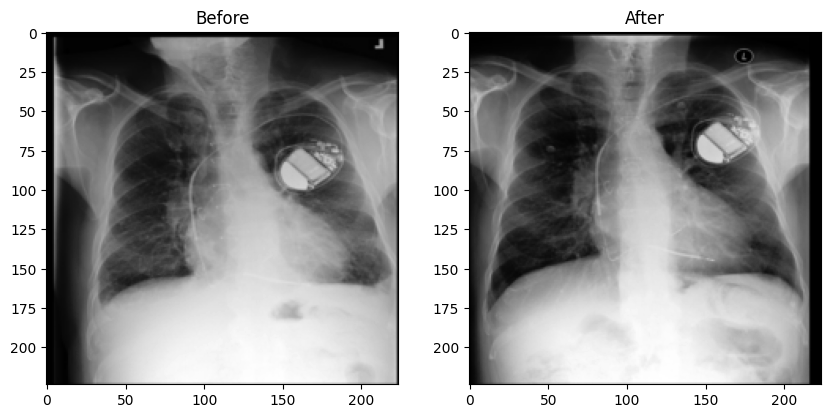

In [ ]:
"""
This block of code gives out sample two images, and tests out how the model reacts
"""

row = train_df.iloc[random.randint(0, len(train_df)-1)]
prev_img = prevpkl[row["object_id"]]
prev_img = grayscale(prev_img)
curr_img = currentpkl[row["subject_id"]]
curr_img = grayscale(curr_img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].title.set_text("Before")
ax[1].title.set_text("After")

ax[0].imshow(torch.permute(prev_img, (1, 2, 0)), cmap='gray')
ax[1].imshow(torch.permute(curr_img, (1, 2, 0)), cmap='gray')

progression_dict = {"no change": "no change", "worsened": "changed", "improved": "changed"}

pe = row['comparison']
print(f"Reference: {pe} " + (f"({progression_dict[pe]})" if pe != "no change" else ""))
print(f"Generated: {predict(prev_img, curr_img)}")